# Belief State Geometry Replication

Replicating [a paper](https://arxiv.org/pdf/2405.15943) by Adam Shai et al. on belief state geometries in transformer models. 

## Defining Data Generating Process

In [86]:
import numpy as np
import torch
# Define transition matrices
T_A = np.array([
    [0.765, 0.00375, 0.00375],
    [0.0425, 0.0675, 0.00375],
    [0.0425, 0.00375, 0.0675]
])

T_B = np.array([
    [0.0675, 0.0425, 0.00375],
    [0.00375, 0.765, 0.00375],
    [0.00375, 0.0425, 0.0675]
])

T_C = np.array([
    [0.0675, 0.00375, 0.0425],
    [0.00375, 0.0675, 0.0425],
    [0.00375, 0.00375, 0.765]
])

transition_matrices = np.array([T_A, T_B, T_C])

def generate_mess3_data(n_samples=1000, seq_length=100, transition_matrices = transition_matrices):
    """
    Generate sequences of tokens based on provided transition matrices for the mess3 process.

    Arguments:
    n_samples -- Number of sequences to generate
    seq_length -- Length of each sequence
    transition_matrices -- List of transition matrices for each token type

    Returns:
    sequences -- List of generated sequences, shape [n_samples, seq_length]
    state_sequences -- List of state sequences corresponding to the generated sequences
    """
    # Stack matrices for easier sampling
    T_combined = np.stack([T_A, T_B, T_C], axis=0)
    tokens = ['A', 'B', 'C']  # Corresponding to indices 0, 1, 2
    n_states = 3
    
    # Generate sequences
    sequences = []
    state_sequences = []
    
    for _ in range(n_samples):
        # Start in a random state
        current_state = np.random.randint(0, n_states)
        seq = []
        states = [current_state]
        
        for _ in range(seq_length):
            # Create flattened view of transition probabilities from current state
            # trans_probs is shape [# token matrices, # states, # states]
            trans_probs = T_combined[:, current_state, :].flatten()

            # Sample from the joint distribution
            # E.g. if idx = 0, 1, or 2, it means that the first token is generated and we move to state 0, 1, or 2 respectively
            idx = np.random.choice(len(trans_probs), p=trans_probs)
            # Convert flat index to token and next state
            token_idx = idx // n_states  # Which matrix (token)
            next_state = idx % n_states  # Which column (next state)
            
            # Record token and update state
            seq.append(tokens[token_idx])
            current_state = next_state
            states.append(current_state)
        
        sequences.append("".join(seq))
        state_sequences.append(states[:-1])  # Remove the last state (no token emitted)
    
    return sequences, state_sequences

In [87]:
# Note: Could likely vectorize this function for better performance
def get_belief_state(observed_tokens, transition_matrices, return_all=False):
    """
    Update the belief state based on observed tokens and transition matrices.
    
    Args:
        observed_tokens: Observed Input tokens (list of lists of strings), shape [batch_size, seq_length]
        transition_matrices: Transition matrices for each token, shape [d_vocab, n_states, n_states]
        return_all: If True, returns all intermediate belief states
        
    Returns:
        belief_state: Updated belief state after processing the observed tokens
            If return_all is False: shape [batch_size, n_states]
            If return_all is True: shape [batch_size, seq_length, n_states]
    """
    batch_size = len(observed_tokens)
    seq_length = len(observed_tokens[0])
    n_states = transition_matrices.shape[1]
    
    # Convert observed tokens to indices
    token_indices = text_to_tokens(observed_tokens)  # shape [batch_size, seq_length]
    
    # Initialize belief states for each sequence in the batch
    # Create uniform belief state for each sequence in batch
    initial_belief = np.ones((batch_size, n_states)) / n_states
    
    if return_all:
        # Initialize storage for all belief states (including initial)
        # Shape: [batch_size, seq_length, n_states]
        all_belief_states = np.zeros((batch_size, seq_length, n_states))
        all_belief_states[:, 0, :] = initial_belief
    
    # Current belief state for each sequence
    current_belief = initial_belief.copy()  # shape [batch_size, n_states]
    
    # Process each time step for all sequences simultaneously
    for t in range(seq_length):
        # Get token indices for this time step across all sequences
        current_tokens = token_indices[:, t]  # shape [batch_size]
        
        # Update belief state for each sequence
        for b in range(batch_size):
            # Get transition matrix for the current token
            transition = transition_matrices[current_tokens[b], :, :]
            
            # Update belief state using matrix multiplication
            current_belief[b] = current_belief[b] @ transition
            
            # Normalize
            current_belief[b] = current_belief[b] / current_belief[b].sum()
        
        if return_all:
            all_belief_states[:, t, :] = current_belief
    
    if return_all:
        return all_belief_states
    else:
        return current_belief

In [88]:
def text_to_tokens(batch_tokens):
    """
    Convert a batch of token sequences to their corresponding indices in a numpy array.
    
    Args:
        batch_tokens: List of strings, where each string contains tokens to convert
        
    Returns:
        numpy array of indices with shape [batch_size, seq_length]
    """
    assert(type(batch_tokens) == list)
    # Define the mapping dictionary
    token_to_index = {'A': 0, 'B': 1, 'C': 2}
    
    # Initialize result list
    result = []
    
    # Process each sequence in the batch
    for sequence in batch_tokens:
        # Convert tokens to indices for this sequence
        indices = [token_to_index[token.upper()] for token in sequence]
        result.append(indices)
    
    # Convert to numpy array
    return np.array(result)

def tokenizer(batch_strings, device="cpu"):
    """
    Tokenize a batch of strings and convert to tensor.
    """
    tokens = torch.tensor(text_to_tokens(batch_strings))
    tokens.to(device)
    return tokens

In [89]:
# Define model configuration
config = {
    "d_model": 64,           # Embedding dimension
    "n_layers": 32,            # Just 1 layer as requested
    "n_heads": 4,             # Number of attention heads
    "d_head": 64,             # Dimension of each attention head
    "d_mlp": 128,             # Hidden dimension of the MLP
    "n_ctx": 100,             # Context window size
    "d_vocab": 3,         # Vocabulary size
    "act_fn": "silu",         # Activation function
    "normalization_type": "LN", # Layer normalization
}

In [94]:
import matplotlib.pyplot as plt

def plot_belief_simplex_simple(belief_states, title="Belief State Simplex", 
                              figsize=(10, 8), save_path=None, alpha=0.7,
                              point_size=10, marker='o'):
    """
    Create a simple simplex visualization for 3D belief states, 
    with each point colored according to its probability values as RGB.
    
    Args:
        belief_states: numpy array of shape [n_points, 3] containing probability distributions
        title: title for the plot
        figsize: figure size as tuple (width, height)
        save_path: path to save the figure (optional)
        alpha: transparency of points
        point_size: size of the points
        marker: marker style for points
    """
    # Reshape to [n_points, 3] if needed
    if belief_states.ndim > 2:
        original_shape = belief_states.shape
        belief_states = belief_states.reshape(-1, 3)
        print(f"Reshaped belief states from {original_shape} to {belief_states.shape}")
    
    # Define the vertices of the simplex
    corners = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2]])
    
    # Function to convert from barycentric to Cartesian coordinates
    def barycentric_to_cartesian(points):
        return np.dot(points, corners)
    
    # Convert belief states to cartesian coordinates
    cartesian_coords = barycentric_to_cartesian(belief_states)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot each belief state as a point with its own RGB color  
    # Clip colors to avoid values outside [0, 1]  
    ax.scatter(cartesian_coords[:, 0], cartesian_coords[:, 1], 
               c=np.clip(belief_states,0,1), s=point_size, alpha=alpha, marker=marker)
    
    # Draw simplex triangle outline
    ax.plot([corners[0, 0], corners[1, 0]], [corners[0, 1], corners[1, 1]], 'k-', lw=1)
    ax.plot([corners[1, 0], corners[2, 0]], [corners[1, 1], corners[2, 1]], 'k-', lw=1)
    ax.plot([corners[2, 0], corners[0, 0]], [corners[2, 1], corners[0, 1]], 'k-', lw=1)
    
    # Set plot properties
    ax.set_aspect('equal')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 0.95)
    ax.set_title(title, fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    return fig, ax

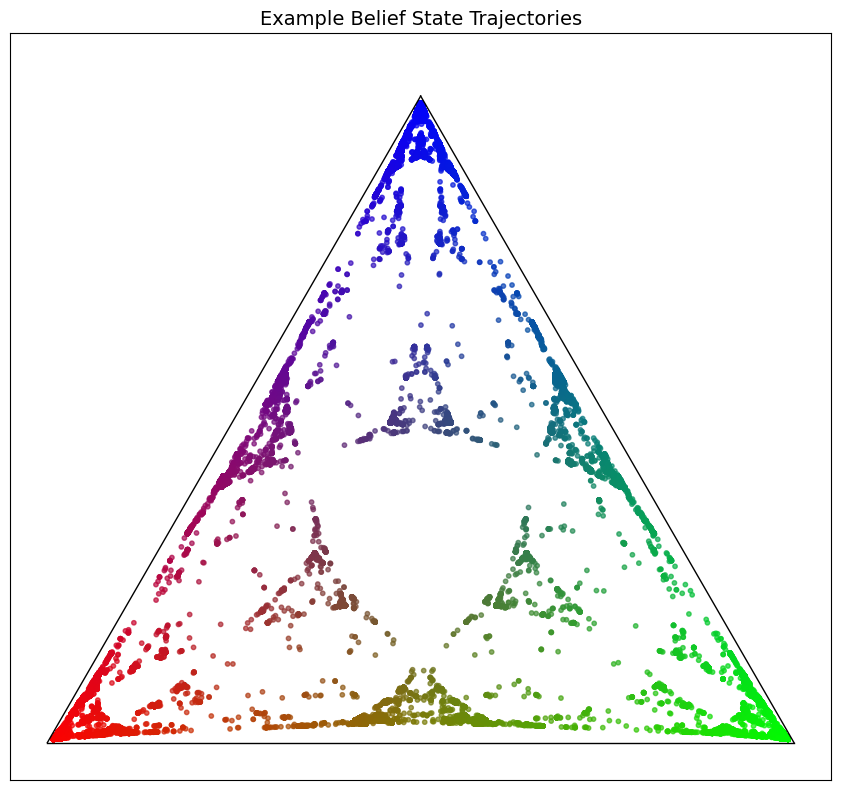

In [99]:
# Let's try it out to confirm the simplex
sequences, _ = generate_mess3_data(n_samples=100000, seq_length=10)
belief_states = get_belief_state(sequences, transition_matrices)
plot_belief_simplex_simple(belief_states, title="Example Belief State Trajectories")
plt.show()

# Training the Transformer Model

Great! Now that we have the belief state dataset in working order, we need to train the transformer model on the dataset. 

## Instantiating the model

In [100]:
import torch
from transformer_lens import HookedTransformer, utils

# Create an untrained transformer model
model = HookedTransformer(config)

# Initialize the model with the random weights
model.__init__(config, tokenizer=None) 
model.cuda()

Moving model to device:  cuda


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-31): 32 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_re

Define cross entropy loss given logits of the model on a batch of tokens 

In [101]:
def lm_cross_entropy_loss(logits, targets, last_only=False):
    # Logits have shape [batch, position, d_vocab]
    # Targets have shape [batch, position]
    log_probs = logits.log_softmax(dim=-1)

    # Throw away the last logit since it has no target
    log_probs = log_probs[:, :-1, :]  # shape [batch, position-1, d_vocab]

    # Gather the log probabilities at the target positions. Don't consider the first token, as there is no context.
    true_class_log_probs = log_probs.gather(dim=-1, index=targets[:, 1:].unsqueeze(-1)).squeeze(-1)
    
    if last_only:
        # Only consider the last token in the sequence
        # Arbitrarily choose to only consider the last 3 tokens
        true_class_log_probs = true_class_log_probs[-3:]
    return (-true_class_log_probs).mean()


## Model Training

Now, we want to train the transformer model on the dataset.

In [102]:
lr = 1e-3
weight_decay = 0

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
losses = []
val_losses = []
log_every = 200
num_epochs = 4000

model.cuda()
model.train()

# Create validation set
validation_size = 1000
val_set = tokenizer(generate_mess3_data(n_samples=validation_size, seq_length=config["n_ctx"])[0])
val_set = val_set.cuda()

batch_size = 64

accumulated_loss = 0
print("Starting training...")
for epoch in range(num_epochs):
    tokens = tokenizer(generate_mess3_data(n_samples=batch_size, seq_length=config["n_ctx"])[0])
    tokens = tokens.cuda()

    # Forward pass
    logits = model(tokens)
    loss = lm_cross_entropy_loss(logits, tokens)
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    # scheduler.step()
    optimizer.zero_grad()
    
    current_loss = loss.item()
    losses.append(current_loss)
    accumulated_loss += current_loss
    
    if epoch % log_every == 0 and epoch > 0:
        print(f"Epoch: {epoch}, Loss: {accumulated_loss/log_every:.4f}")
        accumulated_loss = 0

        with torch.no_grad():
            val_logits = model(val_set)
            val_loss = lm_cross_entropy_loss(val_logits, val_set)
            val_losses.append(val_loss.item())
            print(f"Validation Loss: {val_loss:.4f}")

Moving model to device:  cuda
Epoch: 200, Loss: 0.8842
Validation Loss: 0.8120
Epoch: 400, Loss: 0.8035
Validation Loss: 0.8023
Epoch: 600, Loss: 0.8005
Validation Loss: 0.8001
Epoch: 800, Loss: 0.7971
Validation Loss: 0.7987
Epoch: 1000, Loss: 0.7970
Validation Loss: 0.7982
Epoch: 1200, Loss: 0.7975
Validation Loss: 0.7976
Epoch: 1400, Loss: 0.7963
Validation Loss: 0.7966
Epoch: 1600, Loss: 0.7953
Validation Loss: 0.7972
Epoch: 1800, Loss: 0.7960
Validation Loss: 0.7970
Epoch: 2000, Loss: 0.7963
Validation Loss: 0.7973
Epoch: 2200, Loss: 0.7965
Validation Loss: 0.7974
Epoch: 2400, Loss: 0.7967
Validation Loss: 0.7973
Epoch: 2600, Loss: 0.7967
Validation Loss: 0.7971
Epoch: 2800, Loss: 0.7969
Validation Loss: 0.7962
Epoch: 3000, Loss: 0.7962
Validation Loss: 0.7969
Epoch: 3200, Loss: 0.7963
Validation Loss: 0.7962
Epoch: 3400, Loss: 0.7961
Validation Loss: 0.7964
Epoch: 3600, Loss: 0.7951
Validation Loss: 0.7964
Epoch: 3800, Loss: 0.7969
Validation Loss: 0.7970


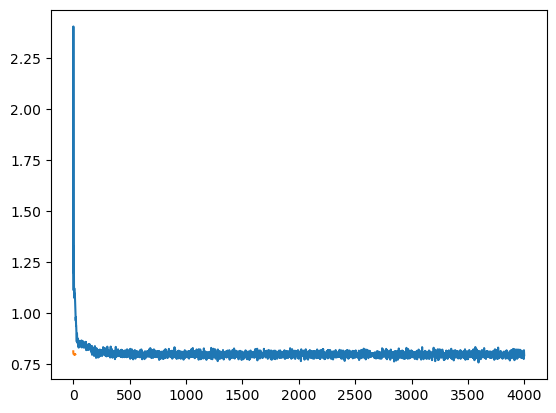

In [103]:
plt.plot(losses)
plt.plot(val_losses)

## Finding a linear mapping between model activations and beliefs states

OK. Now that the model is trained, we can collect all of its activations and compare these against the belief states.

Let's try it with all of the layers residual connections. Note: I think that the "resid_post" key is the correct one for the final residuals from each block?...


In [105]:
from sklearn.linear_model import LinearRegression
from torch.utils.data import TensorDataset, DataLoader

# Change this to select the number of tokens for linear mapping
num_tokens_for_linear = 10000

model.eval()

def generate_tokens_and_belief_states(num_tokens, config, transition_matrices):
    # Generate tokens for linear regression
    tokens = generate_mess3_data(n_samples=num_tokens_for_linear, seq_length=config["n_ctx"])[0]

    # Generate optimal computed belief states from these tokens
    belief_states = get_belief_state(tokens, transition_matrices, return_all=True)
    belief_states = belief_states.reshape(-1, belief_states.shape[-1])

    tokens = tokenizer(tokens)
    tokens = tokens.cuda()

    return tokens, belief_states

# Generate tokens, belief states
tokens, belief_states = generate_tokens_and_belief_states(num_tokens_for_linear, config, transition_matrices)

def get_activations(tokens, resid_keys):
    # Collects activations in batches and stores to the CPU
    activations = []

    test_dataset = TensorDataset(tokens)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for test_tokens in test_dataloader:
        test_tokens = test_tokens[0].to("cuda")
        temp = model.run_with_cache(test_tokens)
        # Add activations to CPU memory
        temp_activation = [temp[1][key] for key in resid_keys]
        temp_activation = torch.cat(temp_activation, dim=-1)
        activations.append(temp_activation.to("cpu"))

    activations = torch.cat(activations, dim=0)
    activations = activations.reshape(-1, activations.shape[-1])
    return activations

# Generate activations
resid_keys = [f"blocks.{i}.hook_resid_post" for i in range(config["n_layers"])]
activations = get_activations(tokens, resid_keys)

print("Shape of belief states:", belief_states.shape)
print("Shape of activations:", activations.shape)

Shape of belief states: (1000000, 3)
Shape of activations: torch.Size([1000000, 2048])


In [106]:
def linear_model(belief_states, activations):
    # Fit linear regression model
    lin_model = LinearRegression()
    return lin_model.fit(activations, belief_states)

# Confine belief states to 2D, as they really only have 2 DOF
belief_states = belief_states[:, :-1]
print("Shape of belief states after confining to 2D:", belief_states.shape)

# Fit linear regression model
linear_model = linear_model(belief_states, activations)

Shape of belief states after confining to 2D: (1000000, 2)


(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Predicted Belief State Simplex'}>)

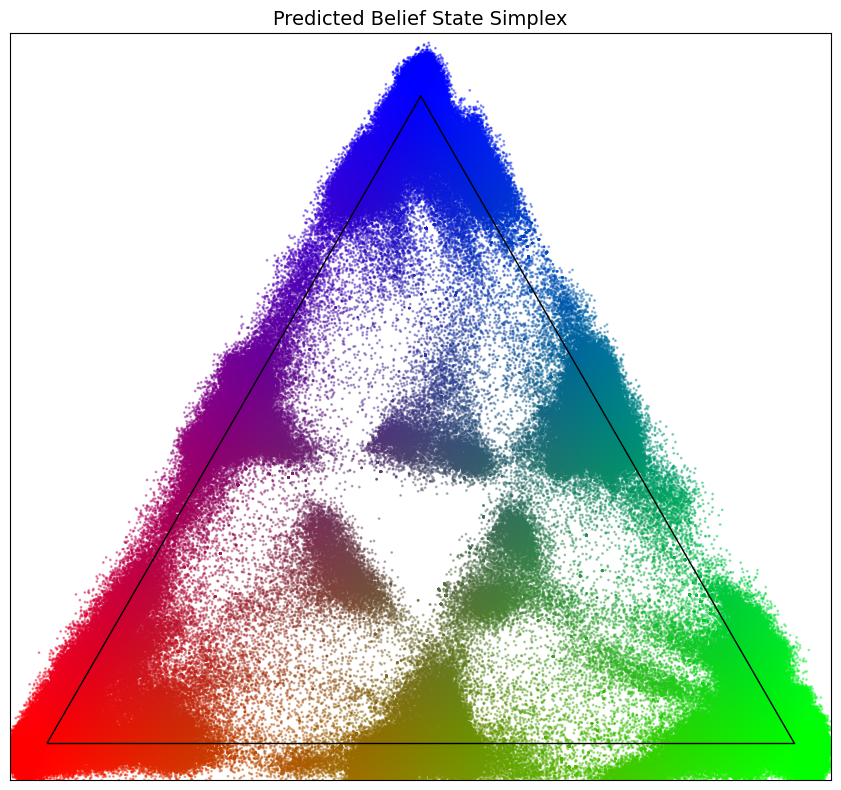

In [107]:
# Find predicted belief states
belief_states_pred = linear_model.predict(activations)
# Reinstate the 3rd dimension to belief states
belief_states_pred = np.column_stack((belief_states_pred, 1 - np.sum(belief_states_pred, axis=1)))
# Plot predicted belief states on the simplex
plot_belief_simplex_simple(belief_states_pred, title="Predicted Belief State Simplex", alpha = 0.4, point_size=1)

Looks decent... I could go for a bit more of a crisp image, but you can definitely tell that this is similar to the predicted belief state geometry above.